# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.3:1.2:1.1:1.1:1.0:1.0:1.2:1.1:1.1
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.2:1.5:1.0:1.5:1.3:1.1:1.1:1.3:1.1:1.3
-------------------------------------
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       706 |     610 |     96 |
|  1 |       796 |     676 |    120 |
|  2 |       746 |     665 |     81 |
|  3 |       703 |     585 |    118 |
|  4 |       692 |     586 |    106 |
|  5 |       622 |     536 |     86 |
|  6 |       644 |     557 |     87 |
|  7 |       735 |     627 |    108 |
|  8 |       666 |     577 |     89 |
|  9 |       690 |     581 |    109 |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")
print(f"This can be seen in atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       7
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       0
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       4
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       2
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3

Every row in the column contains the data of one image, with shape: (28, 28, 1)
This can be seen in atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 256}
Evaluation --> f1_weighted: 0.9500  Best f1_weighted: 0.9500
Time iteration: 13.096s   Total time: 13.100s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9444  Best f1_weighted: 0.9500
Time iteration: 8.520s   Total time: 21.623s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9434  Best f1_weighted: 0.9500
Time iteration: 8.589s   Total time: 30.216s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9476  Best f1_weighted: 0.9500
Time iteration: 8.733s   Total time: 39.143s
Initial point 5 ---------------------------------
Parameters --> {

## Analyze the results

In [8]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[8.1364737e-09, 1.2038348e-07, 8.1679536e-07, ..., 1.8898286e-06,
        1.2574749e-05, 1.9167864e-08],
       [9.9999237e-01, 8.8796721e-09, 5.5650673e-07, ..., 3.1534778e-08,
        3.5454404e-09, 2.1204627e-08],
       [5.2014917e-09, 3.4863130e-09, 1.4086155e-05, ..., 1.2405106e-04,
        2.8541785e-05, 9.6071737e-05],
       ...,
       [6.3510655e-11, 2.9130268e-10, 1.5597187e-10, ..., 1.1295973e-12,
        3.9354007e-05, 5.7942435e-07],
       [1.3509514e-08, 5.1740532e-09, 1.9764679e-09, ..., 1.7607146e-10,
        5.0104972e-12, 2.9206788e-13],
       [2.0834084e-05, 1.0599989e-05, 8.6403816e-05, ..., 9.1196409e-05,
        9.9849904e-01, 1.2492186e-03]], dtype=float32)

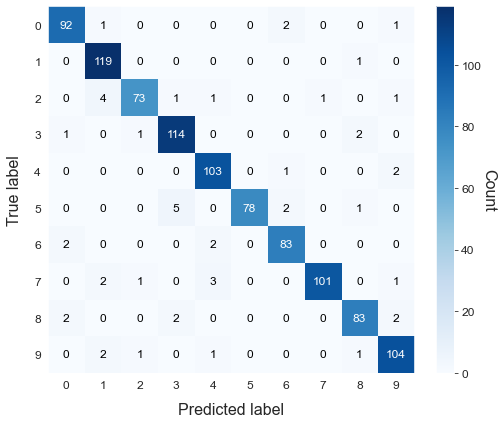

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()